# Clustering Toronto Neighborhoods Project Notebook

## 1. Web Scraping and Preparing data

#### Importing libraries

In [1]:
%%capture

import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

! pip install folium==0.5.0
import folium # plotting library

#### Webscraping and setting up df with postal codes of Toronto Boroughs & Neighborhoods

In [2]:
from bs4 import BeautifulSoup

url = 'http://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)

if page.status_code != 200:
    print('Could not retrieve webpage')

soup = BeautifulSoup(page.text, 'lxml')

In [3]:
# Using code from "Tips for  Webscraping Updated Table in Week3 Peer Graded Assignment"
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

display(df.shape)
df.head()

(103, 3)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


#### Webscraping and preparing latitude/longitude data for merge

In [4]:
url_geo = 'https://cocl.us/Geospatial_data'

df_geo = pd.read_csv(url_geo)

display(df_geo.shape)
df_geo.head()

(103, 3)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
df_geo = df_geo.rename(columns={'Postal Code': 'PostalCode'})

df_geo.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
# Merge Postal Code Data to LL Data

In [7]:
df_toronto = df.merge(df_geo, on='PostalCode')

df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


## 2. Mapping and Clustering Toronto Neighborhoods

In [8]:
# Use Geopy Library to get Latitude and Longitude of Toronto, Ontario, Canada 

address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of toronto are 43.6534817, -79.3839347.


#### Create map of Toronto neighborhoods

In [9]:
# Create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Simplify the above map and segment and cluster only the neighborhoods in 

In [10]:
# Determine which part of Toronto to focus on, pick the one with most neighborhoods
df_toronto['Borough'].value_counts()

North York                24
Downtown Toronto          17
Scarborough               17
Etobicoke                 11
Central Toronto            9
West Toronto               6
York                       5
East Toronto               4
East York                  4
Mississauga                1
East Toronto Business      1
Etobicoke Northwest        1
East York/East Toronto     1
Queen's Park               1
Downtown Toronto Stn A     1
Name: Borough, dtype: int64

In [11]:
#select all neigborhoods of North York Borough
NY_data = df_toronto[df_toronto['Borough'] == 'North York'].reset_index(drop=True)
display(NY_data.shape)
display(NY_data.info())
NY_data.head()

(24, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PostalCode    24 non-null     object 
 1   Borough       24 non-null     object 
 2   Neighborhood  24 non-null     object 
 3   Latitude      24 non-null     float64
 4   Longitude     24 non-null     float64
dtypes: float64(2), object(3)
memory usage: 1.1+ KB


None

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
3,M3B,North York,Don Mills North,43.745906,-79.352188
4,M6B,North York,Glencairn,43.709577,-79.445073


In [12]:
# get geographical coordinates

address_NY = 'North York, Toronto, On, Canada'

geolocator = Nominatim(user_agent="NorthYork_explorer")
location = geolocator.geocode(address)
latitude_NY = location.latitude
longitude_NY = location.longitude
print('The geograpical coordinate of North York are {}, {}.'.format(latitude_NY, longitude_NY))


The geograpical coordinate of North York are 43.6534817, -79.3839347.


#### Visualize North York neighborhoods

In [13]:
# create map of Manhattan using latitude and longitude values
map_NorthYork = folium.Map(location=[latitude_NY, longitude_NY], zoom_start=11)

# add markers to map
for lat, lng, label in zip(NY_data['Latitude'], NY_data['Longitude'], NY_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NorthYork)  
    
map_NorthYork

## 3. Exploring North York's Neighborhoods

### 3.1. First explore one neighborhood

In [14]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'G4EHZJQYOZ0KGN3FZHY1KVW2H0P35SPDL1JWTDENJ5T0ZO0L' # your Foursquare ID
CLIENT_SECRET = 'BF152LX32OOGU2ZY2PTZDMEVDMHLTF32CRF5DH0AYC3E5CUM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: G4EHZJQYOZ0KGN3FZHY1KVW2H0P35SPDL1JWTDENJ5T0ZO0L
CLIENT_SECRET:BF152LX32OOGU2ZY2PTZDMEVDMHLTF32CRF5DH0AYC3E5CUM


#### Let's explore the first neighborhood in the dataframe


Get the neighborhood's name.


In [15]:
NY_data.loc[0, 'Neighborhood']

'Parkwoods'

#### Get the neighborhood's latitude and longitude values.


In [16]:
neighborhood_latitude = NY_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = NY_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = NY_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


#### Get the top 100 venues that are in Parkwoods within a radius of 500 meters.


In [17]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=G4EHZJQYOZ0KGN3FZHY1KVW2H0P35SPDL1JWTDENJ5T0ZO0L&client_secret=BF152LX32OOGU2ZY2PTZDMEVDMHLTF32CRF5DH0AYC3E5CUM&v=20180605&ll=43.7532586,-79.3296565&radius=500&limit=100'

In [18]:
# Get requests and examine results

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60653a9380e010057033a52e'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 43.757758604500005,
    'lng': -79.32343823984928},
   'sw': {'lat': 43.7487585955, 'lng': -79.33587476015072}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': 

In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
# cleaning json and structuring it to df

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

<ipython-input-20-f6f33db48198>:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [21]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

2 venues were returned by Foursquare.


#### Parkwoods looks like a residential area with a park and a store. See also the warning in the heading of the json file.

### 3.2 Explore Neighborhoods in North York

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
# Run function and create new df
NY_venues = getNearbyVenues(names=NY_data['Neighborhood'],
                                   latitudes=NY_data['Latitude'],
                                   longitudes=NY_data['Longitude']
                                  )


Parkwoods
Victoria Village
Lawrence Manor, Lawrence Heights
Don Mills North
Glencairn
Don Mills South
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Fairview, Henry Farm, Oriole
Northwood Park, York University
Bayview Village
Downsview East
York Mills, Silver Hills
Downsview West
North Park, Maple Leaf Park, Upwood Park
Humber Summit
Willowdale, Newtonbrook
Downsview Central
Bedford Park, Lawrence Manor East
Humberlea, Emery
Willowdale South
Downsview Northwest
York Mills West
Willowdale West


#### Note that Postal Codes can spread out over several neighborhoods

In [24]:
# Check size
NY_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
Don Mills North,4,4,4,4,4,4
Don Mills South,21,21,21,21,21,21
Downsview Central,3,3,3,3,3,3
Downsview East,3,3,3,3,3,3
Downsview Northwest,5,5,5,5,5,5
Downsview West,3,3,3,3,3,3


#### How many unique categories can be curated from all the returned venues?


In [25]:
print('There are {} uniques categories.'.format(len(NY_venues['Venue Category'].unique())))

There are 99 uniques categories.


## 3.3 Analyze Each Neighborhood


In [26]:
# one hot encoding
NY_onehot = pd.get_dummies(NY_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NY_onehot['Neighborhood'] = NY_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NY_onehot.columns[-1]] + list(NY_onehot.columns[:-1])
NY_onehot = NY_onehot[fixed_columns]

NY_onehot.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,...,Sporting Goods Shop,Supermarket,Supplement Shop,Sushi Restaurant,Thai Restaurant,Theater,Toy / Game Store,Video Game Store,Vietnamese Restaurant,Women's Store
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
NY_onehot.shape

(245, 100)

#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [28]:
NY_grouped = NY_onehot.groupby('Neighborhood').mean().reset_index()
NY_grouped

,Neighborhood,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,...,Sporting Goods Shop,Supermarket,Supplement Shop,Sushi Restaurant,Thai Restaurant,Theater,Toy / Game Store,Video Game Store,Vietnamese Restaurant,Women's Store
0,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.086957,...,0.000000,0.043478,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Bayview Village,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Bedford Park, Lawrence Manor East",0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.041667,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000
3,Don Mills North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Don Mills South,0.000000,0.000000,0.000000,0.047619,0.000000,0.047619,0.0,0.000000,0.000000,...,0.047619,0.047619,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Downsview Central,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Downsview East,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Downsview Northwest,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Downsview West,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Fairview, Henry Farm, Oriole",0.000000,0.000000,0.014493,0.000000,0.000000,0.014493,0.0,0.028986,0.028986,...,0.014493,0.000000,0.014493,0.000000,0.000000,0.014493,0.014493,0.014493,0.000000,0.014493


In [29]:
NY_grouped.shape

(23, 100)

#### Print each neighborhood along with the top 5 most common venues

In [30]:
num_top_venues = 5

for hood in NY_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = NY_grouped[NY_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bathurst Manor, Wilson Heights, Downsview North----
                venue  freq
0         Coffee Shop  0.09
1                Bank  0.09
2  Frozen Yogurt Shop  0.04
3   Mobile Phone Shop  0.04
4               Diner  0.04


----Bayview Village----
                 venue  freq
0   Chinese Restaurant  0.25
1                 Café  0.25
2                 Bank  0.25
3  Japanese Restaurant  0.25
4    Accessories Store  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.08
1           Juice Bar  0.08
2         Coffee Shop  0.08
3      Sandwich Place  0.08
4    Greek Restaurant  0.04


----Don Mills North----
                  venue  freq
0                   Gym  0.25
1  Caribbean Restaurant  0.25
2                  Café  0.25
3   Japanese Restaurant  0.25
4                Lounge  0.00


----Don Mills South----
                venue  freq
0         Coffee Shop  0.10
1          Restaurant  0.10
2                 Gym  0.10
3  Chinese Restauran

#### Put it into a _pandas_ dataframe

In [31]:
#  Function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
# Create the new dataframe and display the top 10 venues for each neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NY_grouped['Neighborhood']

for ind in np.arange(NY_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NY_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Middle Eastern Restaurant,Ice Cream Shop,Bridal Shop,Pharmacy,Mobile Phone Shop,Pizza Place,Deli / Bodega,Intersection
1,Bayview Village,Chinese Restaurant,Bank,Café,Japanese Restaurant,Fried Chicken Joint,Food Truck,Coffee Shop,Furniture / Home Store,Comfort Food Restaurant,Construction & Landscaping
2,"Bedford Park, Lawrence Manor East",Juice Bar,Coffee Shop,Italian Restaurant,Sandwich Place,Greek Restaurant,Restaurant,Café,Butcher,Comfort Food Restaurant,Indian Restaurant
3,Don Mills North,Caribbean Restaurant,Gym,Café,Japanese Restaurant,Women's Store,Diner,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store
4,Don Mills South,Coffee Shop,Gym,Restaurant,Chinese Restaurant,Sandwich Place,Italian Restaurant,Bike Shop,Beer Store,Discount Store,Clothing Store
5,Downsview Central,Food Truck,Home Service,Baseball Field,Women's Store,Discount Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop
6,Downsview East,Airport,Park,Business Service,Women's Store,Diner,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop
7,Downsview Northwest,Grocery Store,Gym / Fitness Center,Athletics & Sports,Liquor Store,Discount Store,Women's Store,Diner,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping
8,Downsview West,Park,Bank,Shopping Mall,Women's Store,Diner,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store
9,"Fairview, Henry Farm, Oriole",Clothing Store,Coffee Shop,Fast Food Restaurant,Mobile Phone Shop,Shoe Store,Restaurant,Juice Bar,Bakery,Bank,Japanese Restaurant


## 3.4. Cluster Neighborhoods

In [33]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [34]:
# Run _k_-means to cluster the neighborhood into 5 clusters

# set number of clusters
kclusters = 3

NY_grouped_clustering = NY_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NY_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
# Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

NY_merged = NY_data

# merge NY_grouped with NY_data to add latitude/longitude for each neighborhood
NY_merged = NY_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

display(NY_merged.info()) #check NA values
NY_merged.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PostalCode              24 non-null     object 
 1   Borough                 24 non-null     object 
 2   Neighborhood            24 non-null     object 
 3   Latitude                24 non-null     float64
 4   Longitude               24 non-null     float64
 5   Cluster Labels          23 non-null     float64
 6   1st Most Common Venue   23 non-null     object 
 7   2nd Most Common Venue   23 non-null     object 
 8   3rd Most Common Venue   23 non-null     object 
 9   4th Most Common Venue   23 non-null     object 
 10  5th Most Common Venue   23 non-null     object 
 11  6th Most Common Venue   23 non-null     object 
 12  7th Most Common Venue   23 non-null     object 
 13  8th Most Common Venue   23 non-null     object 
 14  9th Most Common Venue   23 non-null     obje

None

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2.0,Park,Food & Drink Shop,Diner,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,0.0,Coffee Shop,Hockey Arena,Pizza Place,Portuguese Restaurant,Women's Store,Dim Sum Restaurant,Clothing Store,Comfort Food Restaurant,Construction & Landscaping,Convenience Store
2,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Clothing Store,Accessories Store,Boutique,Furniture / Home Store,Coffee Shop,Vietnamese Restaurant,Asian Restaurant,Athletics & Sports,Construction & Landscaping,Convenience Store
3,M3B,North York,Don Mills North,43.745906,-79.352188,0.0,Caribbean Restaurant,Gym,Café,Japanese Restaurant,Women's Store,Diner,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store
4,M6B,North York,Glencairn,43.709577,-79.445073,0.0,Pizza Place,Japanese Restaurant,Park,Bakery,Women's Store,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store


In [36]:
# drop NA value (1 found)
NY_merged = NY_merged.dropna()
NY_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 0 to 23
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PostalCode              23 non-null     object 
 1   Borough                 23 non-null     object 
 2   Neighborhood            23 non-null     object 
 3   Latitude                23 non-null     float64
 4   Longitude               23 non-null     float64
 5   Cluster Labels          23 non-null     float64
 6   1st Most Common Venue   23 non-null     object 
 7   2nd Most Common Venue   23 non-null     object 
 8   3rd Most Common Venue   23 non-null     object 
 9   4th Most Common Venue   23 non-null     object 
 10  5th Most Common Venue   23 non-null     object 
 11  6th Most Common Venue   23 non-null     object 
 12  7th Most Common Venue   23 non-null     object 
 13  8th Most Common Venue   23 non-null     object 
 14  9th Most Common Venue   23 non-null     obje

In [37]:
# Change NY_merged to int
NY_merged['Cluster Labels'] =NY_merged['Cluster Labels'].astype(int) 

In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NY_merged['Latitude'], NY_merged['Longitude'], NY_merged['Neighborhood'], NY_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 4. Conclusion: Examine clusters and characterize them

## Cluster 1: Mixed-Use Cluster

In [39]:
NY_merged.loc[NY_merged['Cluster Labels'] == 0, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,0,Coffee Shop,Hockey Arena,Pizza Place,Portuguese Restaurant,Women's Store,Dim Sum Restaurant,Clothing Store,Comfort Food Restaurant,Construction & Landscaping,Convenience Store
2,North York,0,Clothing Store,Accessories Store,Boutique,Furniture / Home Store,Coffee Shop,Vietnamese Restaurant,Asian Restaurant,Athletics & Sports,Construction & Landscaping,Convenience Store
3,North York,0,Caribbean Restaurant,Gym,Café,Japanese Restaurant,Women's Store,Diner,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store
4,North York,0,Pizza Place,Japanese Restaurant,Park,Bakery,Women's Store,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store
5,North York,0,Coffee Shop,Gym,Restaurant,Chinese Restaurant,Sandwich Place,Italian Restaurant,Bike Shop,Beer Store,Discount Store,Clothing Store
6,North York,0,Golf Course,Mediterranean Restaurant,Fast Food Restaurant,Pool,Dog Run,Dim Sum Restaurant,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping
7,North York,0,Coffee Shop,Bank,Middle Eastern Restaurant,Ice Cream Shop,Bridal Shop,Pharmacy,Mobile Phone Shop,Pizza Place,Deli / Bodega,Intersection
8,North York,0,Clothing Store,Coffee Shop,Fast Food Restaurant,Mobile Phone Shop,Shoe Store,Restaurant,Juice Bar,Bakery,Bank,Japanese Restaurant
9,North York,0,Vietnamese Restaurant,Furniture / Home Store,Caribbean Restaurant,Metro Station,Coffee Shop,Massage Studio,Bar,Miscellaneous Shop,Women's Store,Department Store
10,North York,0,Chinese Restaurant,Bank,Café,Japanese Restaurant,Fried Chicken Joint,Food Truck,Coffee Shop,Furniture / Home Store,Comfort Food Restaurant,Construction & Landscaping


### ==> Cluster 1 is the mixed use cluster. It has assorted stores, restaurants and coffeeshops. Also, there are recreational spaces, like parks or a baseball field, and there is business/transportation use of space (landscaping, airport).

## Cluster 2: Bedroom Cluster


In [40]:
NY_merged.loc[NY_merged['Cluster Labels'] == 1, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,North York,1,Piano Bar,Women's Store,Diner,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega


In [41]:
# Analyze cluster
NY_merged['Neighborhood'].iloc[15]

'Willowdale, Newtonbrook'

Top 5 most common venues of the neighborhood(s) (normalized)

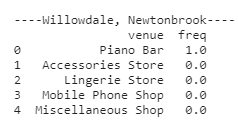

### ==> Cluster 2 is the 'bedroom neigborhood' cluster: it mostly used for sleeping, residents work and socialize elsewhere.

## Cluster 3: Residential Cluster


In [42]:
NY_merged.loc[NY_merged['Cluster Labels'] == 2, NY_merged.columns[[1] + list(range(5, NY_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,2,Park,Food & Drink Shop,Diner,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop
22,North York,2,Park,Convenience Store,Diner,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Cosmetics Shop,Deli / Bodega


In [43]:
# Analyze cluster NY_grouped
display(NY_merged['Neighborhood'].iloc[0])
NY_merged['Neighborhood'].iloc[21]

'Parkwoods'

'York Mills West'

Top 5 most common venues of the neighborhood(s) (normalized)

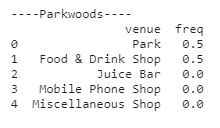

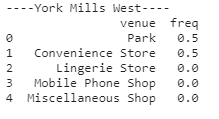

### ==> Cluster 3 is the residential cluster: it is determined by spaces in which people live and socialize. The businesses in this area focus on day-to-day needs.

# Thank you!
